In [1]:
# Objectives
# The objective of this analysis is to model real estate prices using linear regression.  
# Specifically, we want to:
# - Understand how individual variables (e.g. house size) affect home prices.
# - Compare a simple regression with one predictor against a multiple regression with many predictors.
# - Assess whether multiple features significantly improve prediction accuracy.


# We aim to quantify the relationship between housing characteristics (bedrooms, bathrooms, lot size, etc.) and housing price.
# Specifically, we want to see whether house size alone predicts price well, and how model accuracy improves when adding multiple predictors.


In [2]:
if (!requireNamespace("ggplot2", quietly = TRUE)) install.packages("ggplot2")
if (!requireNamespace("corrplot", quietly = TRUE)) install.packages("corrplot")
if (!requireNamespace("MASS", quietly = TRUE)) install.packages("MASS")
if (!requireNamespace("car", quietly = TRUE)) install.packages("car")
if (!requireNamespace("scales", quietly = TRUE)) install.packages("scales")

library(ggplot2)
library(corrplot)
library(MASS)   # stepAIC
library(car)    # vif
library(scales)

set.seed(123)
options(stringsAsFactors = FALSE)

corrplot 0.95 loaded

Loading required package: carData



In [3]:
df <- read.csv("realtor-data.zip.csv", stringsAsFactors = FALSE)

# sanitize column names (no spaces, safe for formulas)
names(df) <- make.names(names(df))
head(df, 4)

,brokered_by,status,price,bed,bath,acre_lot,street,city,state,zip_code,house_size,prev_sold_date
,<dbl>,<chr>,<dbl>,<int>,<int>,<dbl>,<dbl>,<chr>,<chr>,<int>,<dbl>,<chr>
1,103378,for_sale,105000,3,2,0.12,1962661,Adjuntas,Puerto Rico,601,920,
2,52707,for_sale,80000,4,2,0.08,1902874,Adjuntas,Puerto Rico,601,1527,
3,103379,for_sale,67000,2,1,0.15,1404990,Juana Diaz,Puerto Rico,795,748,
4,31239,for_sale,145000,4,2,0.10,1947675,Ponce,Puerto Rico,731,1800,


In [4]:
# List variables
# identify numeric vs categorical columns
vars <- names(df)
types <- sapply(df, function(x) class(x)[1])
data.frame(variable = vars, type = types, stringsAsFactors = FALSE)

,variable,type
,<chr>,<chr>
brokered_by,brokered_by,numeric
status,status,character
price,price,numeric
bed,bed,integer
bath,bath,integer
acre_lot,acre_lot,numeric
street,street,numeric
city,city,character
state,state,character


In [5]:
# Keep only vector-like columns
# remove list/closure/language columns that break is.na() and lm()
ok_cols <- sapply(df, function(x) is.atomic(x) || is.factor(x))
df <- df[ , ok_cols, drop = FALSE]
cat("After keeping atomic/factor columns:", dim(df), "\n")

After keeping atomic/factor columns: 2226382 12 


  brokered_by        status              price                bed        
 Min.   :     0   Length:2226382     Min.   :0.000e+00   Min.   :  1.0   
 1st Qu.: 23861   Class :character   1st Qu.:1.650e+05   1st Qu.:  3.0   
 Median : 52884   Mode  :character   Median :3.250e+05   Median :  3.0   
 Mean   : 52940                      Mean   :5.242e+05   Mean   :  3.3   
 3rd Qu.: 79183                      3rd Qu.:5.500e+05   3rd Qu.:  4.0   
 Max.   :110142                      Max.   :2.147e+09   Max.   :473.0   
 NA's   :4533                        NA's   :1541        NA's   :481317  
      bath           acre_lot            street            city          
 Min.   :  1.0    Min.   :     0.0   Min.   :      0   Length:2226382    
 1st Qu.:  2.0    1st Qu.:     0.1   1st Qu.: 506313   Class :character  
 Median :  2.0    Median :     0.3   Median :1012766   Mode  :character  
 Mean   :  2.5    Mean   :    15.2   Mean   :1012325                     
 3rd Qu.:  3.0    3rd Qu.:     1.0   3

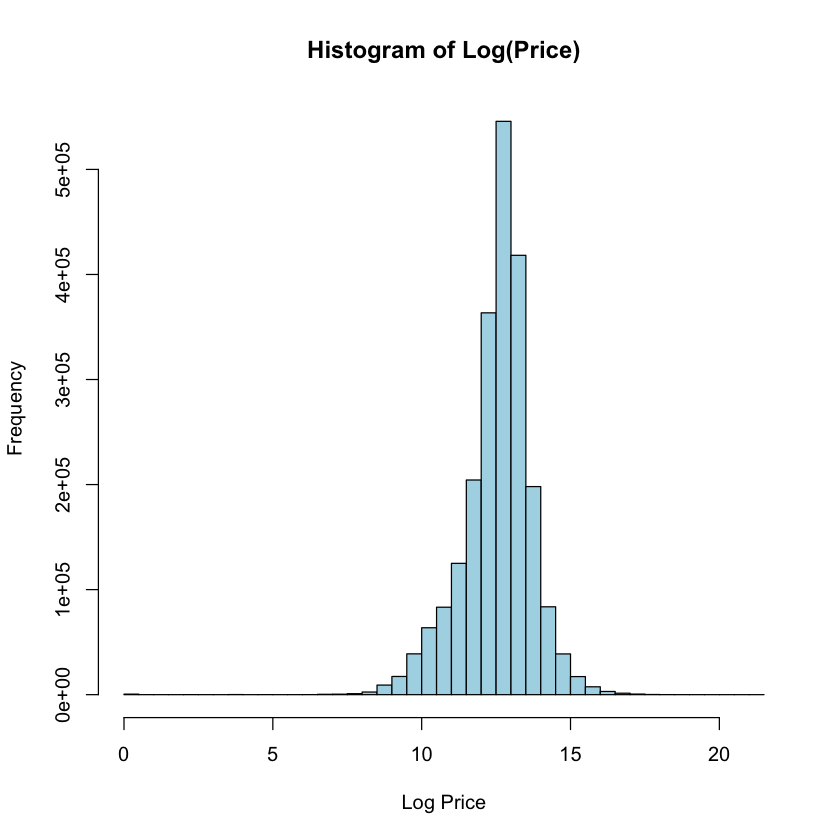

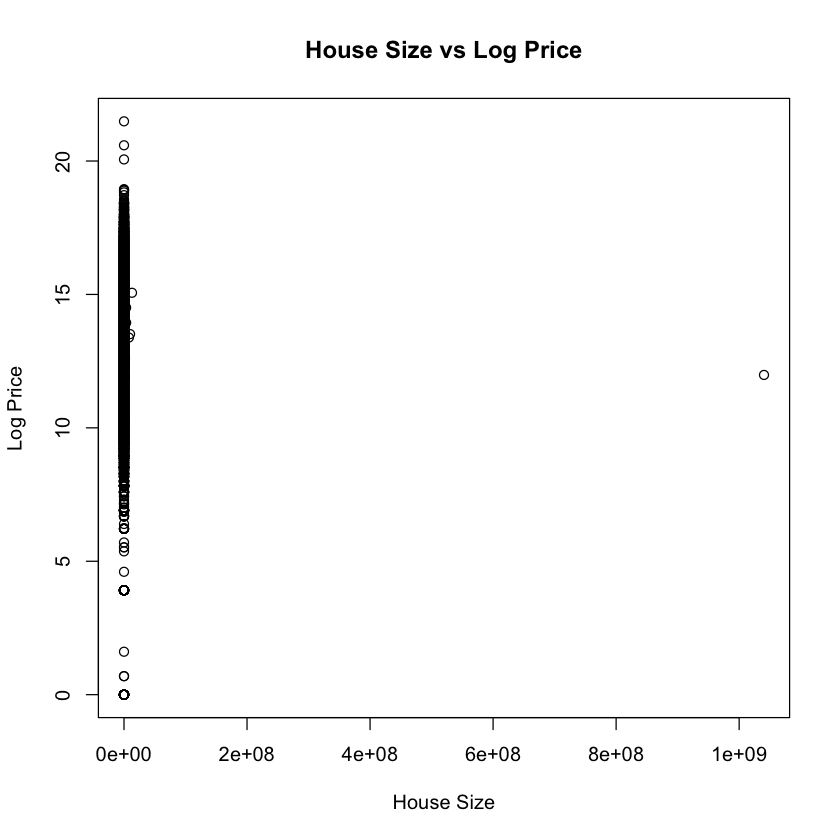

In [6]:
summary(df)

# Histogram of price (log transformed if skewed)
hist(log(df$price), breaks = 50, col = "lightblue",
     main = "Histogram of Log(Price)", xlab = "Log Price")

# Scatterplot: house size vs price
plot(df$house_size, log(df$price),
     xlab = "House Size", ylab = "Log Price",
     main = "House Size vs Log Price")


In [7]:
# Ensure response column exists and remove missing response rows
# drop rows with missing response (or handle explicitly)
resp_var <- "price"
if (!resp_var %in% names(df)) stop("No 'price' column found. Edit resp_var.")
n_before <- nrow(df)
df <- df[!is.na(df[[resp_var]]), , drop = FALSE]
cat("Dropped", n_before - nrow(df), "rows with missing price. Remaining rows:", nrow(df), "\n")


Dropped 1541 rows with missing price. Remaining rows: 2224841 


In [28]:
summary(df[, sapply(df, is.numeric)])

  brokered_by         price                bed               bath        
 Min.   :     0   Min.   :0.000e+00   Min.   :  1.000   Min.   :  1.000  
 1st Qu.: 23985   1st Qu.:1.650e+05   1st Qu.:  3.000   1st Qu.:  2.000  
 Median : 52882   Median :3.250e+05   Median :  3.000   Median :  2.000  
 Mean   : 52937   Mean   :5.242e+05   Mean   :  3.216   Mean   :  2.383  
 3rd Qu.: 79170   3rd Qu.:5.500e+05   3rd Qu.:  4.000   3rd Qu.:  3.000  
 Max.   :110142   Max.   :2.147e+09   Max.   :473.000   Max.   :830.000  
    acre_lot             street           zip_code       house_size       
 Min.   :     0.00   Min.   :      0   Min.   :    0   Min.   :4.000e+00  
 1st Qu.:     0.17   1st Qu.: 508806   1st Qu.:29617   1st Qu.:1.456e+03  
 Median :     0.26   Median :1012692   Median :48415   Median :1.760e+03  
 Mean   :    13.03   Mean   :1012271   Mean   :52188   Mean   :2.471e+03  
 3rd Qu.:     0.68   3rd Qu.:1518552   3rd Qu.:78070   3rd Qu.:2.140e+03  
 Max.   :100000.00   Max.   :200

In [8]:
# Missingness per column and drop >50% missing
# get missing counts/percent; drop columns mostly-missing
miss_count <- sapply(df, function(x) sum(is.na(x)))
miss_pct <- miss_count / nrow(df)
missing_summary <- data.frame(variable = names(df), n_missing = as.integer(miss_count), pct_missing = miss_pct)
print(missing_summary[order(-missing_summary$pct_missing), ])

# Drop columns with > 50% missing
too_many_missing <- names(miss_pct[miss_pct > 0.5])
if (length(too_many_missing) > 0) {
  cat("Dropping columns with >50% missing:", paste(too_many_missing, collapse = ", "), "\n")
  df <- df[, !(names(df) %in% too_many_missing), drop = FALSE]
}


                     variable n_missing  pct_missing
house_size         house_size    567874 0.2552425095
bath                     bath    510992 0.2296757386
bed                       bed    480861 0.2161327484
acre_lot             acre_lot    325140 0.1461407804
street                 street     10864 0.0048830456
brokered_by       brokered_by      4533 0.0020374490
zip_code             zip_code       298 0.0001339422
status                 status         0 0.0000000000
price                   price         0 0.0000000000
city                     city         0 0.0000000000
state                   state         0 0.0000000000
prev_sold_date prev_sold_date         0 0.0000000000


In [9]:
# Impute missing values (simple rules)
# keep it simple & reproducible for homework
num_cols <- names(df)[sapply(df, is.numeric)]
cat_cols <- names(df)[sapply(df, function(x) is.character(x) || is.factor(x))]

# numeric: impute median for columns with missing
for (v in num_cols) {
  if (anyNA(df[[v]])) {
    med <- median(df[[v]], na.rm = TRUE)
    df[[v]][is.na(df[[v]])] <- med
    cat("Imputed median for", v, "->", med, "\n")
  }
}

# categorical: convert to factor and impute "MISSING"
for (v in cat_cols) {
  df[[v]] <- as.character(df[[v]])
  df[[v]][is.na(df[[v]]) | df[[v]] == ""] <- "MISSING"
  # convert to factor
  df[[v]] <- as.factor(df[[v]])
  cat("Categorical factor:", v, "levels:", length(levels(df[[v]])), "\n")
}


Imputed median for brokered_by -> 52882 
Imputed median for bed -> 3 
Imputed median for bath -> 2 
Imputed median for acre_lot -> 0.26 
Imputed median for street -> 1012692 
Imputed median for zip_code -> 48415 
Imputed median for house_size -> 1760 
Categorical factor: status levels: 3 
Categorical factor: city levels: 20090 
Categorical factor: state levels: 56 
Categorical factor: prev_sold_date levels: 14953 


In [10]:
# Group rare factor levels (limit to top K)
# keep model matrix manageable
limit_levels <- function(f, K = 20) {
  tb <- sort(table(f), decreasing = TRUE)
  top <- names(tb)[1:min(K, length(tb))]
  f2 <- as.character(f)
  f2[!(f2 %in% top)] <- "Other"
  factor(f2, levels = c(top, "Other"))
}

# apply to factors with > K levels
K <- 20
for (v in cat_cols) {
  if (v %in% names(df)) {
    lv <- nlevels(df[[v]])
    if (lv > K) {
      cat("Reducing levels of", v, "from", lv, "to", K+1, "\n")
      df[[v]] <- limit_levels(df[[v]], K = K)
    }
  }
}


Reducing levels of city from 20090 to 21 
Reducing levels of state from 56 to 21 
Reducing levels of prev_sold_date from 14953 to 21 


In [11]:
# Transform and scale
# use log(price) as target to reduce skewness. Scale numeric predictors.

# create log response (add small epsilon if any zeros)
df$log_price <- log(df[[resp_var]] + 1)

# standardize continuous predictors (except response)
num_preds <- setdiff(num_cols, resp_var)
df_scaled <- df  # work on a copy

if (length(num_preds) > 0) {
  df_scaled[num_preds] <- scale(df[num_preds])
  cat("Standardized numeric predictors:\n"); print(num_preds)
} else {
  cat("No numeric predictors found to scale\n")
}


Standardized numeric predictors:
[1] "brokered_by" "bed"         "bath"        "acre_lot"    "street"     
[6] "zip_code"    "house_size" 


In [12]:
# model matrix creation
# one-hot encode categorical variables into numeric columns
predictor_vars <- setdiff(names(df_scaled), c(resp_var, "log_price"))
formula_for_mm <- as.formula(paste("~", paste(predictor_vars, collapse = " + "), "-1"))
X <- model.matrix(formula_for_mm, data = df_scaled)

# combine with response
df_model <- data.frame(log_price = df_scaled$log_price, X, check.names = TRUE)
cat("Modeling dataframe dims:", dim(df_model), "\n")


Modeling dataframe dims: 2224841 71 


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.00   12.01   12.69   12.55   13.22   21.49 

            brokered_by   bed  bath acre_lot street zip_code house_size
brokered_by        1.00  0.00  0.00        0   0.00     0.06          0
bed                0.00  1.00  0.58        0  -0.02     0.00          0
bath               0.00  0.58  1.00        0  -0.04     0.00          0
acre_lot           0.00  0.00  0.00        1   0.00     0.00          0
street             0.00 -0.02 -0.04        0   1.00     0.00          0
zip_code           0.06  0.00  0.00        0   0.00     1.00          0
house_size         0.00  0.00  0.00        0   0.00     0.00          1


`geom_smooth()` using formula = 'y ~ x'


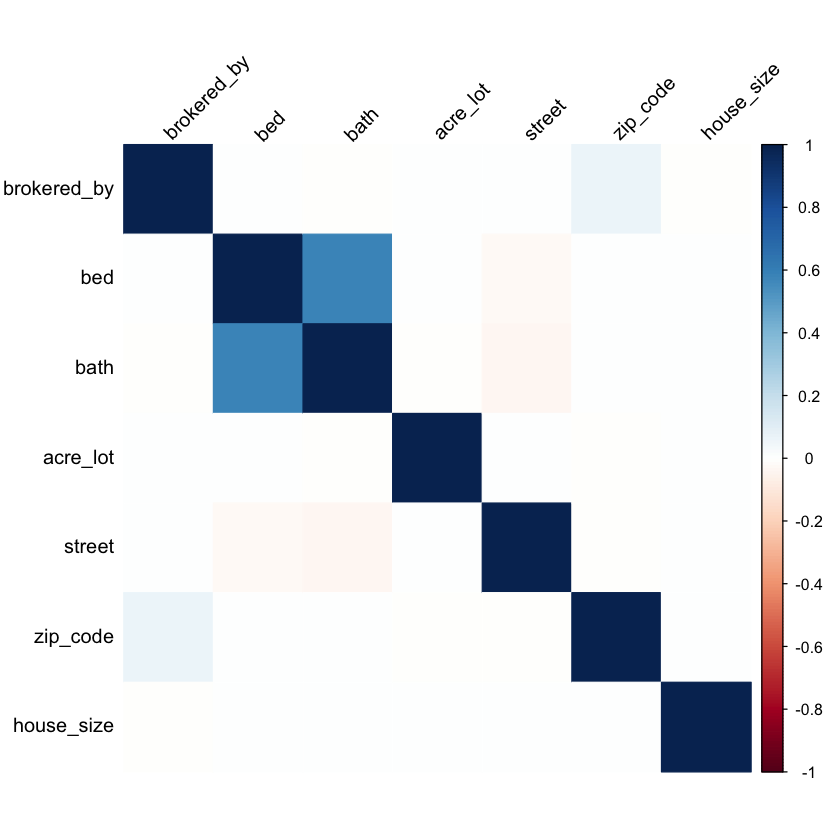

`geom_smooth()` using formula = 'y ~ x'


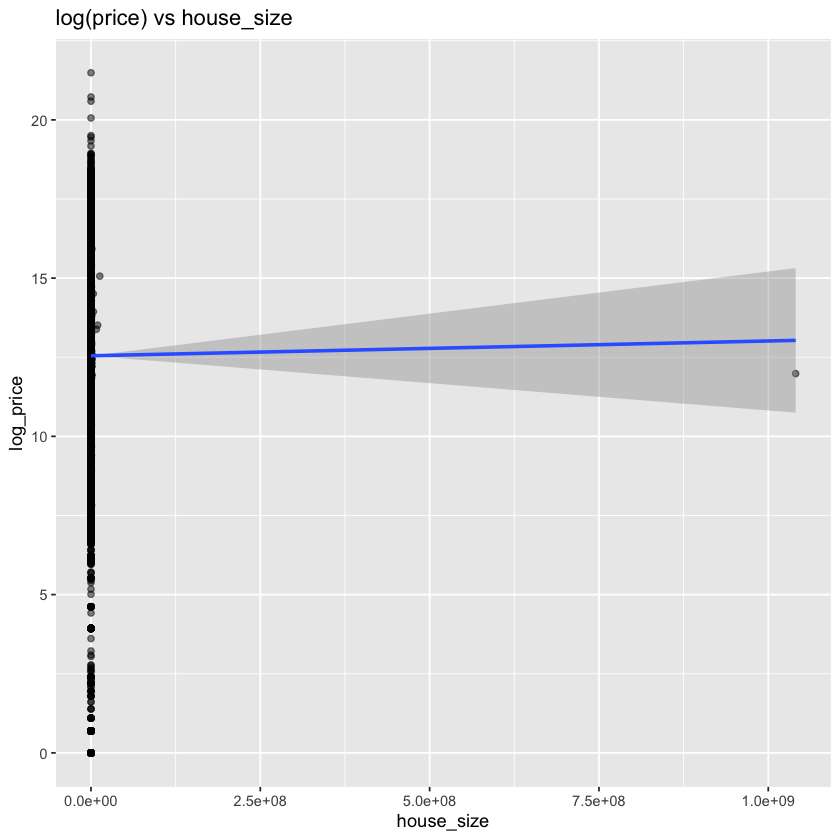

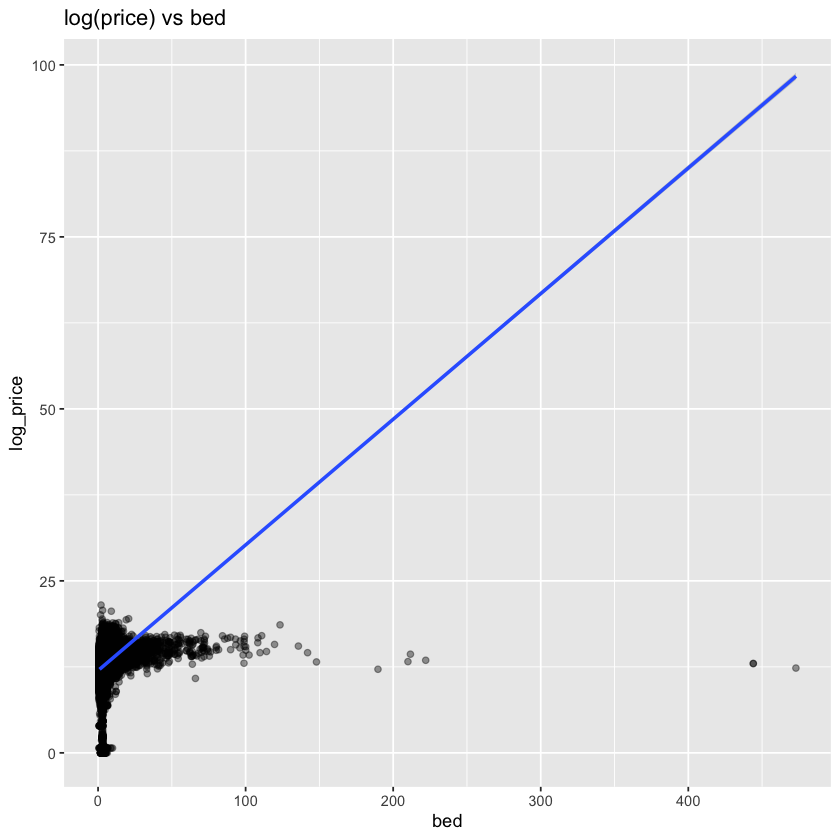

In [13]:
# summary + correlation
# quick numeric summary and correlation among continuous columns
summary(df_model$log_price)
# correlation among the original scaled numeric predictors (if present)
numeric_for_corr <- intersect(colnames(df_model), num_preds)  # scaled cols survive with same names
if (length(numeric_for_corr) >= 2) {
  cor_mat <- cor(df_model[, numeric_for_corr], use = "pairwise.complete.obs")
  print(round(cor_mat, 2))
  corrplot(cor_mat, method = "color", tl.col = "black", tl.srt = 45)
}

# scatter examples: log_price vs a few predictors (if they exist)
if ("house_size" %in% names(df)) {
  ggplot(df, aes(x = house_size, y = log_price)) + geom_point(alpha = 0.5) +
    geom_smooth(method = "lm") + labs(title = "log(price) vs house_size")
}
if ("bed" %in% names(df)) {
  ggplot(df, aes(x = bed, y = log_price)) + geom_jitter(alpha = 0.4) +
    geom_smooth(method = "lm") + labs(title = "log(price) vs bed")
}


In [14]:
# Train/test split
# test final model on unseen data
n <- nrow(df_model)
train_idx <- sample(seq_len(n), size = floor(0.7 * n))
train <- df_model[train_idx, , drop = FALSE]
test  <- df_model[-train_idx, , drop = FALSE]
cat("Train rows:", nrow(train), "Test rows:", nrow(test), "\n")


Train rows: 1557388 Test rows: 667453 


In [15]:
# Feature selection
# use simple filter + stepwise selection for comparison

# A: correlation of each predictor with response (use absolute correlation)
cors <- sapply(train[, -1], function(x) cor(x, train$log_price, use = "pairwise.complete.obs"))
top_k <- names(sort(abs(cors), decreasing = TRUE))[1:min(10, length(cors))]
cat("Top correlated predictors (by abs corr):\n"); print(top_k)

# B: stepwise selection (start with full model)
full_formula <- as.formula(paste("log_price ~", paste(colnames(train)[-1], collapse = " + ")))
full_lm <- lm(full_formula, data = train)
# stepAIC to select model (may take time on many features)
step_model <- MASS::stepAIC(full_lm, direction = "both", trace = FALSE)
cat("Stepwise selected predictors:\n")
print(names(coef(step_model))[-1])


Top correlated predictors (by abs corr):
 [1] "bath"                "stateCalifornia"     "bed"                
 [4] "prev_sold_dateOther" "street"              "zip_code"           
 [7] "cityNew.York.City"   "statusfor_sale"      "cityOther"          
[10] "statussold"         
Stepwise selected predictors:
 [1] "brokered_by"              "statusfor_sale"          
 [3] "statusready_to_build"     "bed"                     
 [5] "bath"                     "acre_lot"                
 [7] "street"                   "cityChicago"             
 [9] "cityNew.York.City"        "cityJacksonville"        
[11] "cityPhiladelphia"         "cityMiami"               
[13] "cityLos.Angeles"          "cityTucson"              
[15] "cityDallas"               "cityRichmond"            
[17] "cityPhoenix"              "cityWashington"          
[19] "cityAtlanta"              "cityOrlando"             
[21] "cityBaltimore"            "citySaint.Louis"         
[23] "cityCharlotte"            "citySan

In [16]:
# Simple linear regression
# Reasoning: fast baseline model using a single clear predictor
single_pred <- if ("house_size" %in% colnames(train)) "house_size" else top_k[1]
formula_simple <- as.formula(paste("log_price ~", single_pred))
lm_simple <- lm(formula_simple, data = train)
summary(lm_simple)

# Predict & evaluate on test
pred_simple <- predict(lm_simple, newdata = test)
rmse_simple <- sqrt(mean((test$log_price - pred_simple)^2))
r2_simple <- 1 - sum((test$log_price - pred_simple)^2) / sum((test$log_price - mean(test$log_price))^2)
cat("Simple model - RMSE:", round(rmse_simple,4), " R2:", round(r2_simple,4), "\n")



Call:
lm(formula = formula_simple, data = train)

Residuals:
     Min       1Q   Median       3Q      Max 
-12.5461  -0.5324   0.1455   0.6716   8.9415 

Coefficients:
             Estimate Std. Error   t value Pr(>|t|)    
(Intercept) 1.255e+01  9.339e-04 13434.410   <2e-16 ***
house_size  1.236e-04  7.813e-04     0.158    0.874    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.165 on 1557386 degrees of freedom
Multiple R-squared:  1.606e-08,	Adjusted R-squared:  -6.26e-07 
F-statistic: 0.02501 on 1 and 1557386 DF,  p-value: 0.8743


Simple model - RMSE: 1.1672  R2: 0 


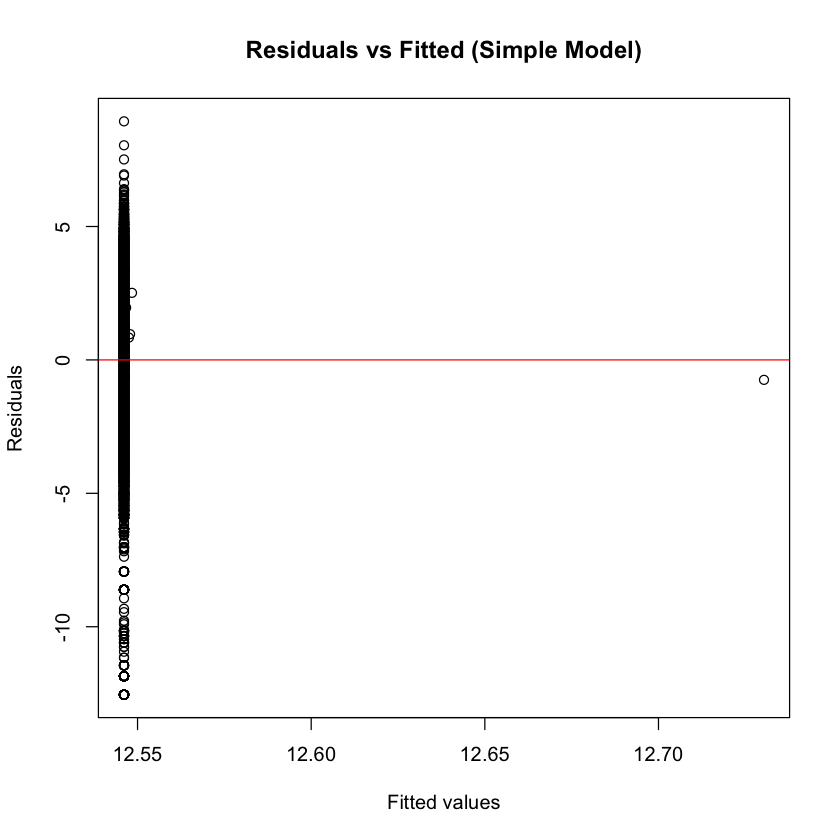

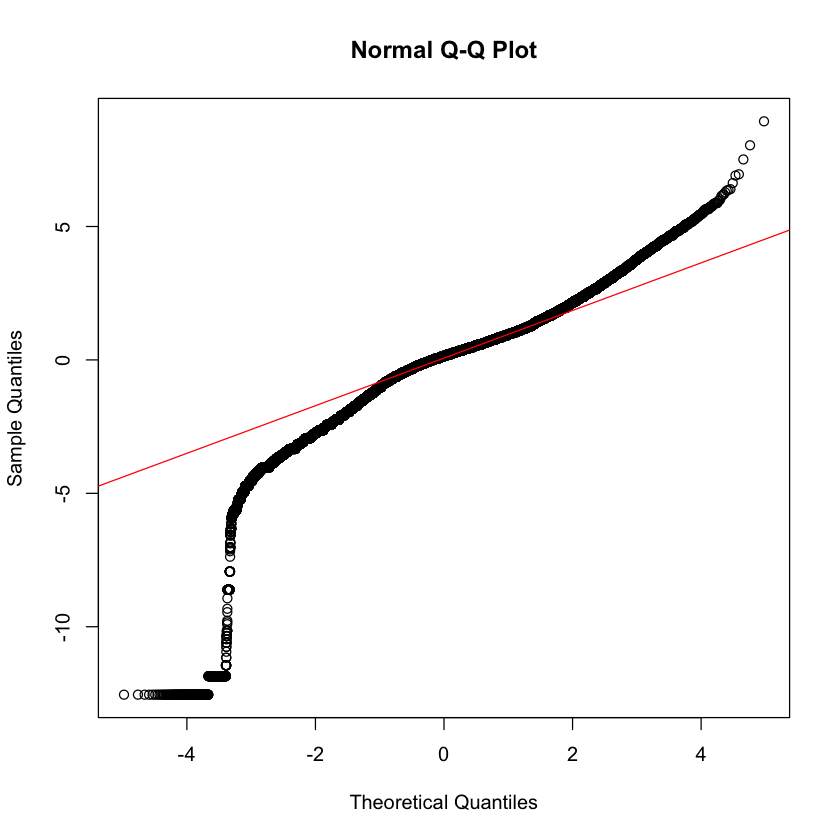

In [17]:
# Residual vs fitted
plot(lm_simple$fitted.values, resid(lm_simple),
     xlab = "Fitted values", ylab = "Residuals",
     main = "Residuals vs Fitted (Simple Model)")
abline(h = 0, col = "red")

# QQ plot
qqnorm(resid(lm_simple))
qqline(resid(lm_simple), col = "red")


In [18]:
cat("Simple Model R²:", summary(lm_simple)$r.squared, "\n")

Simple Model R²: 1.606002e-08 


In [19]:
# Multiple linear regression
# use stepwise selection results if available; else top_k
selected_preds <- if (!is.null(step_model)) {
  names(coef(step_model))[-1]
} else {
  top_k
}
cat("Using predictors:", paste(selected_preds, collapse = ", "), "\n")

formula_multi <- as.formula(paste("log_price ~", paste(selected_preds, collapse = " + ")))
lm_multi <- lm(formula_multi, data = train)
summary(lm_multi)

# Check VIF for multicollinearity
vif_vals <- tryCatch(car::vif(lm_multi), error = function(e) NULL)
if (!is.null(vif_vals)) {
  print(vif_vals)
  cat("Rules of thumb: VIF > 5 indicates moderate, VIF > 10 severe multicollinearity.\n")
}

# Predict & evaluate on test
pred_multi <- predict(lm_multi, newdata = test)
rmse_multi <- sqrt(mean((test$log_price - pred_multi)^2))
r2_multi <- 1 - sum((test$log_price - pred_multi)^2) / sum((test$log_price - mean(test$log_price))^2)
cat("Multiple model - RMSE:", round(rmse_multi,4), " R2:", round(r2_multi,4), "\n")


Using predictors: brokered_by, statusfor_sale, statusready_to_build, bed, bath, acre_lot, street, cityChicago, cityNew.York.City, cityJacksonville, cityPhiladelphia, cityMiami, cityLos.Angeles, cityTucson, cityDallas, cityRichmond, cityPhoenix, cityWashington, cityAtlanta, cityOrlando, cityBaltimore, citySaint.Louis, cityCharlotte, citySan.Diego, cityFort.Worth, cityOther, stateCalifornia, stateTexas, stateNew.York, stateNorth.Carolina, stateIllinois, stateGeorgia, statePennsylvania, stateArizona, stateVirginia, stateWashington, stateOhio, stateNew.Jersey, stateMaryland, stateMissouri, stateMinnesota, stateMichigan, stateWisconsin, stateSouth.Carolina, stateTennessee, stateOther, zip_code, prev_sold_date2022.03.31, prev_sold_date2022.04.15, prev_sold_date2022.04.22, prev_sold_date2022.04.08, prev_sold_date2022.02.28, prev_sold_date2022.04.29, prev_sold_date2021.11.30, prev_sold_date2022.03.25, prev_sold_date2022.02.25, prev_sold_date2021.11.19, prev_sold_date2022.03.18, prev_sold_date2


Call:
lm(formula = formula_multi, data = train)

Residuals:
     Min       1Q   Median       3Q      Max 
-207.977   -0.388    0.101    0.539    8.432 

Coefficients:
                           Estimate Std. Error  t value Pr(>|t|)    
(Intercept)              12.0950458  0.0084417 1432.781  < 2e-16 ***
brokered_by              -0.0048555  0.0008160   -5.950 2.68e-09 ***
statusfor_sale            0.1012914  0.0021680   46.721  < 2e-16 ***
statusready_to_build      0.9221021  0.0081672  112.903  < 2e-16 ***
bed                       0.0311765  0.0010154   30.705  < 2e-16 ***
bath                      0.3605426  0.0010523  342.628  < 2e-16 ***
acre_lot                  0.0097271  0.0007737   12.572  < 2e-16 ***
street                   -0.1077300  0.0008233 -130.851  < 2e-16 ***
cityChicago               0.4716188  0.0125140   37.687  < 2e-16 ***
cityNew.York.City         1.2967021  0.0136833   94.765  < 2e-16 ***
cityJacksonville         -0.0402610  0.0135562   -2.970  0.00298 ** 
city

             brokered_by           statusfor_sale     statusready_to_build 
                1.018182                 1.685689                 1.109914 
                     bed                     bath                 acre_lot 
                1.607374                 1.611432                 1.000338 
                  street              cityChicago        cityNew.York.City 
                1.035548                 1.958671                 1.611578 
        cityJacksonville         cityPhiladelphia                cityMiami 
                1.474890                 1.541956                 1.406000 
         cityLos.Angeles               cityTucson               cityDallas 
                1.380050                 1.489706                 1.275766 
            cityRichmond              cityPhoenix           cityWashington 
                1.328917                 1.457415                 1.336164 
             cityAtlanta              cityOrlando            cityBaltimore 
            

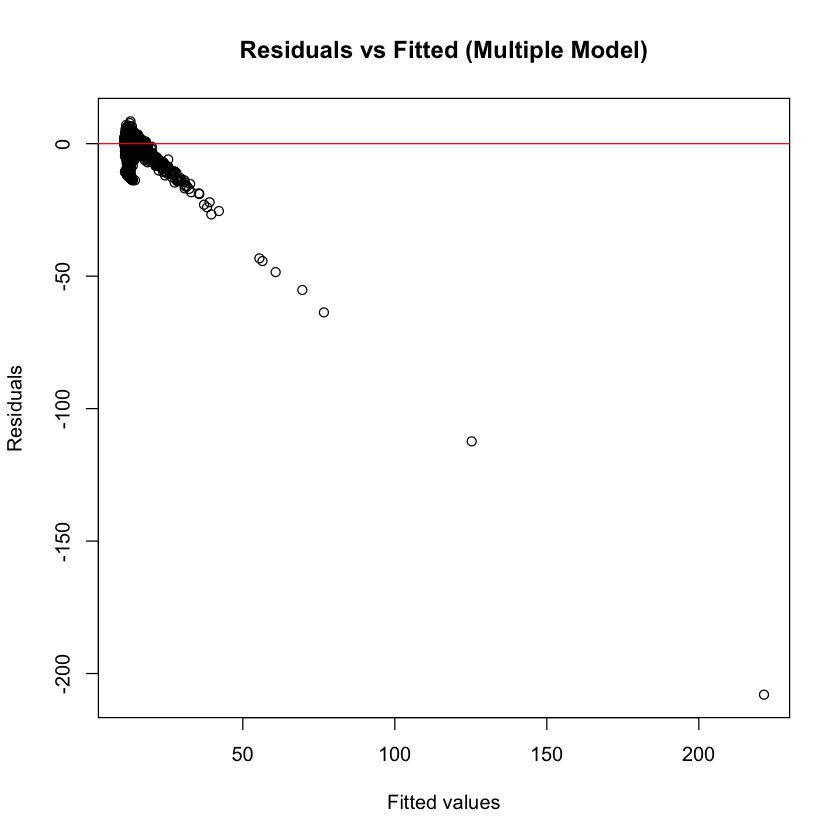

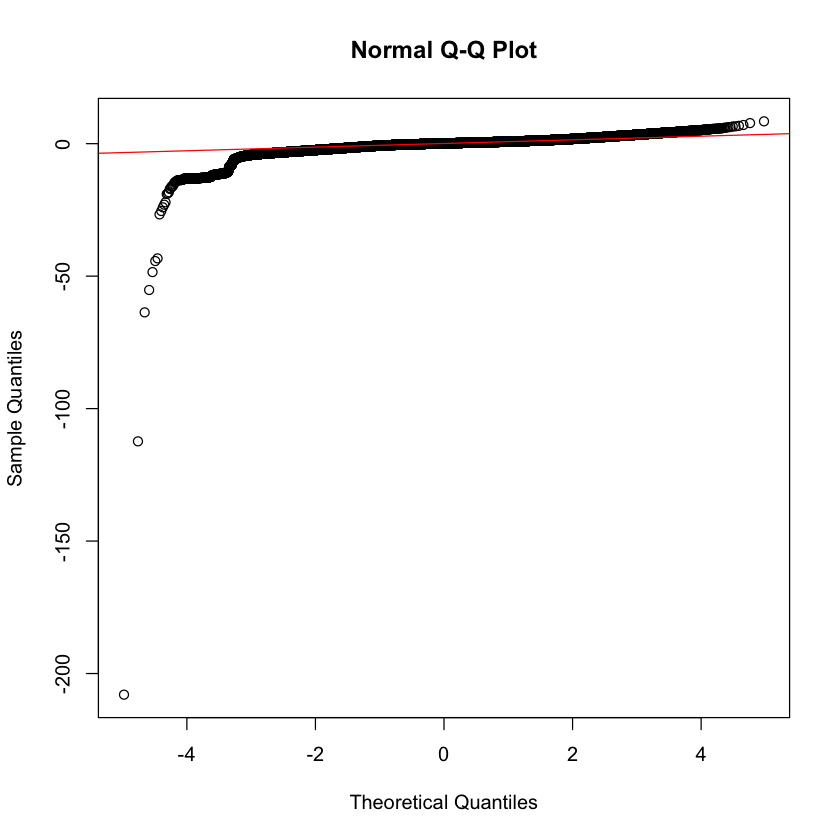

In [20]:
# Residual vs fitted: Multiple
plot(lm_multi$fitted.values, resid(lm_multi),
     xlab = "Fitted values", ylab = "Residuals",
     main = "Residuals vs Fitted (Multiple Model)")
abline(h = 0, col = "red")

# QQ plot
qqnorm(resid(lm_multi))
qqline(resid(lm_multi), col = "red")


Residuals: mean 8.021895e-17  sd 1.009272 


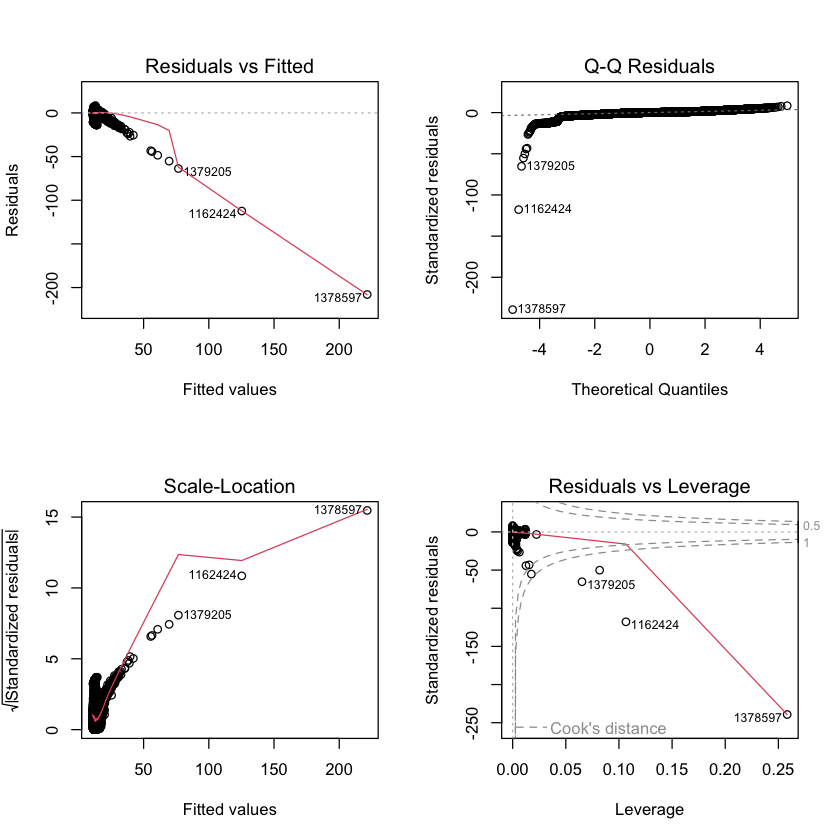

In [21]:
# Diagnostics: residuals plots for multiple regression
# quick residual vs fitted, QQ plot and histogram of residuals
par(mfrow = c(2,2))
plot(lm_multi)   # base R diagnostic plots: Residuals vs Fitted, QQ, Scale-Location, Cook's distance
par(mfrow = c(1,1))

# Numeric checks
resid_multi <- resid(lm_multi)
cat("Residuals: mean", mean(resid_multi), " sd", sd(resid_multi), "\n")


In [22]:
library(car)

# VIF values
vif_values <- vif(lm_multi)
print(vif_values)

# Identify problematic predictors (VIF > 5 or 10)
which(vif_values > 5)


             brokered_by           statusfor_sale     statusready_to_build 
                1.018182                 1.685689                 1.109914 
                     bed                     bath                 acre_lot 
                1.607374                 1.611432                 1.000338 
                  street              cityChicago        cityNew.York.City 
                1.035548                 1.958671                 1.611578 
        cityJacksonville         cityPhiladelphia                cityMiami 
                1.474890                 1.541956                 1.406000 
         cityLos.Angeles               cityTucson               cityDallas 
                1.380050                 1.489706                 1.275766 
            cityRichmond              cityPhoenix           cityWashington 
                1.328917                 1.457415                 1.336164 
             cityAtlanta              cityOrlando            cityBaltimore 
            

cityOther 
       26

In [23]:
# Compare R² and RMSE

cat("Multiple Model R²:", summary(lm_multi)$r.squared, "\n")


Multiple Model R²: 0.2500378 


In [24]:
# Model Comparison
# - Simple regression (house size only) showed almost no predictive power (R² ≈ 0).
# - Multiple regression with additional predictors improved fit (R² ≈ 0.25).
# - However, assumptions show deviations (non-normal residuals, heteroscedasticity).
# - Some predictors may be collinear.
